In [298]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

- Copper: HG
- Bund: RX
- Crude Oil: CL
- EURUSD: EC
- Gold: GC
- Nasdaq: NQ
- S&P500 Mini: ES
- Silver: SI
- Soybeans: SO
- UST: TY

In [367]:
# Load dataset for user-specified ticker, then partitioning into train, cross-validation and test sets
ticker = "HG"
interval = 30                        # Could be either 5, 10, 15, 30, 60 minutes
partitions = [0.65, 0.8]            

with open("clean-data/futures_ticks.pkl", "rb") as f:
    tick_size = pickle.load(f)[ticker]
futures_df = pd.read_csv(f"./clean-data/{ticker}.csv", index_col='datetime', parse_dates=True)

# Resample training set into user-specified intervals
resampled_o = futures_df['open'].resample(f"{interval}min").first()
resampled_h = futures_df['high'].resample(f"{interval}min").max()
resampled_l = futures_df['low'].resample(f"{interval}min").min()
resampled_c = futures_df['close'].resample(f"{interval}min").last()
resampled_v = futures_df['volume'].resample(f"{interval}min").sum()
futures_df = pd.DataFrame(
    {
        'open': resampled_o,
        'high': resampled_h,
        'low': resampled_l,
        'close': resampled_c,
        'volume': resampled_v,
    }
)
futures_df.dropna(inplace=True)

train_df = futures_df.iloc[:int(partitions[0]*len(futures_df))].copy()
cv_df = futures_df.iloc[:int(partitions[1]*len(futures_df))].copy()
test_df = futures_df.copy()

# Construct Range, RangeUp, RangeDown responses
train_df["fwd_range"] = ((train_df["high"] - train_df["low"]) / tick_size).shift(-1)
train_df["fwd_range_up"] = ((train_df["high"] - train_df["open"]) / tick_size).shift(-1)
train_df["fwd_range_down"] = ((train_df["open"] - train_df["low"]) / tick_size).shift(-1)

train_df

,open,high,low,close,volume,fwd_range,fwd_range_up,fwd_range_down
datetime,,,,,,,,
2020-02-24 00:00:00,258.05,258.25,257.95,258.20,107,14.0,12.0,2.0
2020-02-24 00:30:00,258.20,258.80,258.10,258.45,617,7.0,6.0,1.0
2020-02-24 01:00:00,258.40,258.70,258.35,258.60,372,9.0,0.0,9.0
2020-02-24 01:30:00,258.65,258.65,258.20,258.40,412,16.0,5.0,11.0
2020-02-24 02:00:00,258.40,258.65,257.85,258.45,276,23.0,5.0,18.0
...,...,...,...,...,...,...,...,...
2020-05-13 09:00:00,236.70,236.80,236.15,236.70,1870,23.0,0.0,23.0
2020-05-13 09:30:00,236.70,236.70,235.55,235.95,1745,18.0,8.0,10.0
2020-05-13 10:00:00,235.95,236.35,235.45,236.00,1596,21.0,11.0,10.0


In [368]:
# Construct volume, volatility and delta features
tuning_df = train_df.copy()
tuning_df["delta_feat"] = tuning_df["close"].diff()
tuning_df["volume_feat"] = tuning_df["volume"]
tuning_df["vol_feat"] = tuning_df["delta_feat"].rolling(50).std()
tuning_df.dropna(inplace=True)

# Build regime clusters on features
n_regimes = [_ for _ in range(2, 8)]
features = ["delta_feat", "vol_feat", "volume_feat"]
for reg in n_regimes:
    clust_labels = KMeans(n_clusters=reg, random_state=10).fit_predict(tuning_df[features])
    print(reg, silhouette_score(tuning_df[features], clust_labels))

# regimes = 3

# kmeans = KMeans(n_clusters=regimes, random_state=10)
# tuning_df["regime"] = kmeans.fit_predict(tuning_df[features])

# # Build empirical PDF for each response and regime
# regime_obs = tuning_df["regime"].value_counts()
# responses = ["fwd_range", "fwd_range_up", "fwd_range_down"]
# empirical_pdfs = {resp: tuning_df[[resp, "regime"]].groupby("regime").value_counts() / regime_obs for resp in responses}

2 0.6912922270712267
3 0.6189972916908761
4 0.5983940821008567
5 0.5822424719004292
6 0.5789986912118587
7 0.5737644697209532


In [339]:
empirical_pdfs

{'fwd_range': regime  fwd_range
 0       10.0         0.045231
         7.0          0.041790
         11.0         0.038840
         9.0          0.038348
         8.0          0.037856
                        ...   
 2       316.0        0.002331
         326.0        0.002331
         383.0        0.002331
         452.0        0.002331
         777.0        0.002331
 Name: count, Length: 451, dtype: float64,
 'fwd_range_up': regime  fwd_range_up
 0       1.0             0.082596
         4.0             0.070796
         3.0             0.068338
         2.0             0.067355
         5.0             0.059489
                           ...   
 2       220.0           0.002331
         276.0           0.002331
         288.0           0.002331
         346.0           0.002331
         547.0           0.002331
 Name: count, Length: 327, dtype: float64,
 'fwd_range_down': regime  fwd_range_down
 0       1.0               0.087512
         3.0               0.083088
         2.0   

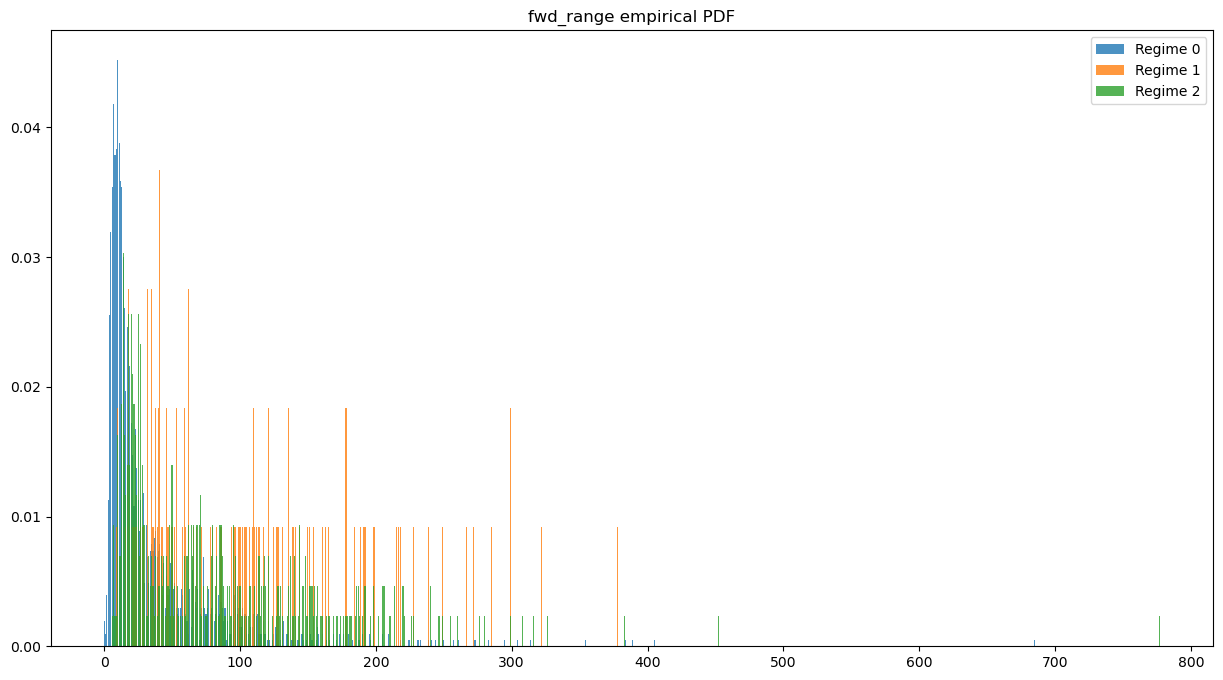

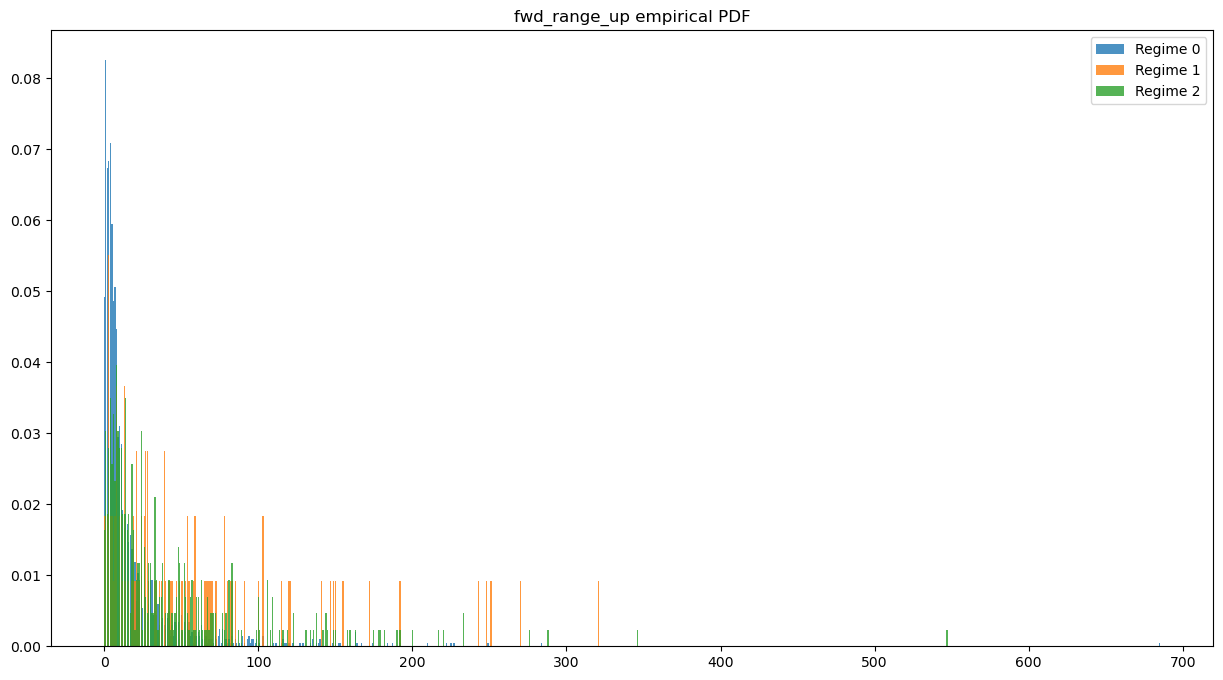

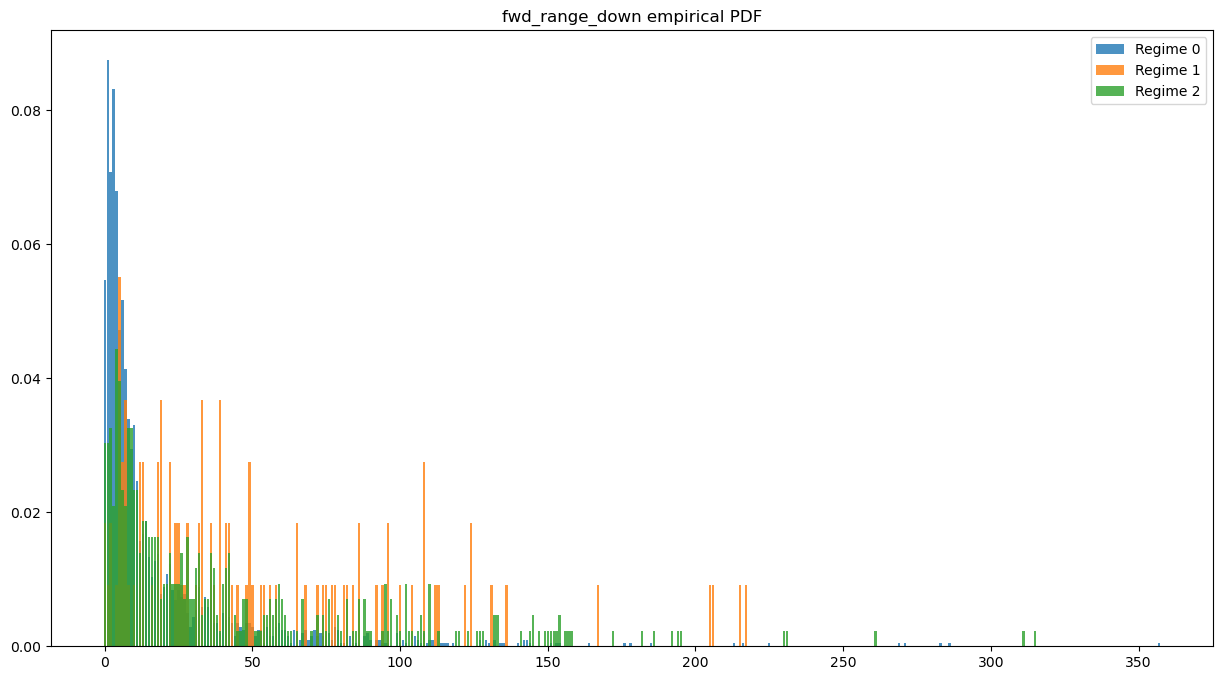

In [335]:
for response, df in empirical_pdfs.items():
    plt.figure(figsize=(15, 8))
    plt.title(f"{response} empirical PDF")
    for i in range(regimes):
        plt.bar(df[i].keys(), df[i].values, label=f"Regime {i}", alpha=0.8)
    plt.legend()

In [336]:
optimizing_df = cv_df.copy()
optimizing_df["fwd_range"] = ((optimizing_df["high"] - optimizing_df["low"]) / tick_size).shift(-1)
optimizing_df["fwd_range_up"] = ((optimizing_df["high"] - optimizing_df["open"]) / tick_size).shift(-1)
optimizing_df["fwd_range_down"] = ((optimizing_df["open"] - optimizing_df["low"]) / tick_size).shift(-1)

optimizing_df["delta_feat"] = optimizing_df["close"].diff()
optimizing_df["volume_feat"] = optimizing_df["volume"]
optimizing_df["vol_feat"] = optimizing_df["delta_feat"].rolling(50).std()
optimizing_df = optimizing_df.iloc[int(partitions[0]*len(futures_df)):].copy()
optimizing_df.dropna(inplace=True)
optimizing_df["regime"] = kmeans.predict(optimizing_df[features])

In [337]:
log_likelihoods = {}
for resp in responses:
    resp_reg_df = optimizing_df[[resp, "regime"]]
    resp_pdf = np.log(empirical_pdfs[resp])
    obs_df = resp_reg_df.groupby("regime").value_counts()
    resp_log_likelihood = 0
    for reg in range(regimes):
        reg_obs_df = obs_df[reg]
        reg_resp_pdf = resp_pdf[reg]
        zero_ll = reg_resp_pdf.min()
        for spread, obs in reg_obs_df.items():
            resp_log_likelihood += obs * reg_resp_pdf.get(spread, zero_ll)
            
    log_likelihoods[resp] = resp_log_likelihood

In [333]:
log_likelihoods

{'fwd_range': -3185.9051838280866,
 'fwd_range_up': -2727.7963716563786,
 'fwd_range_down': -2716.7058453450445}

In [338]:
log_likelihoods

{'fwd_range': -3179.7367100756364,
 'fwd_range_up': -2707.7918698580656,
 'fwd_range_down': -2711.713283367549}

In [ ]:
# Clusters seem to always suggest smaller is better. Should we stick to that
# Polyfit to smoothen out PDF?
# Run actual optimizations
# Clean up code, write some comments

In [ ]:
# Hyperparameters
# Volume: Raw/ SMA (Window size) / EMA (Weight)
# Volatility: SMA (Window size) / EMA (Weight)

# Cluster size: optimize internall